In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
import numpy as np

pd.options.display.max_columns = None
sys.path.append('../')
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.append(os.path.abspath(os.pardir))

from preprocessing import Preprocessor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pickle as pkl

from keras.models import Sequential
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, 'data', 'carer_emotion_dataset')
print(DATA_DIR)

label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

2021-12-16 18:38:33.022756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 18:38:33.022788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/daphne/PycharmProjects/sentiment_task/data/carer_emotion_dataset


## Load dataset

In [2]:
training_data = pd.read_csv(os.path.join(DATA_DIR, 'training.csv'), encoding='utf8')
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), encoding='utf8')
validation_data = pd.read_csv(os.path.join(DATA_DIR, 'validation.csv'), encoding='utf8')

dataset = pd.concat([training_data, test_data, validation_data], ignore_index=True)
dataset = dataset.sample(frac=1)
print(dataset.head())
print(dataset.shape)
print(dataset.columns)

                                                    text  label
19573  i feel privileged to meet true heroes male and...      1
11702  i feel like im the only one there with a brain...      3
4461   i am right now i feel amused the sounds i hear...      1
17091          i feel like being all stubborn and stingy      3
11947  i feel stupid img width height src http voices...      0
(20000, 2)
Index(['text', 'label'], dtype='object')


In [3]:
corpus = []
for i, row in dataset.iterrows():
    preprocessor = Preprocessor(row['text'])
    words_list = preprocessor.get_preprocessed_list_words()
    text = ' '.join(words_list)
    corpus.append(text)
print(corpus[0:10])
# vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

print(X.shape)
y = dataset['label'].copy()

['feel privileged meet true hero male female yet mass unsung world full hero hero old young', 'feel like im one brain rude refuse sit loud rude people sit alone good book', 'right feel amuse sound hear aircleaner around see bed cat feel connect person michael think weird im mom', 'feel like stubborn stingy', 'feel stupid img width height src http voicesfromkrypton', 'invariably feel optimistic focus', 'always feel strange internal feeling like continuous wail siren head nobody hear couldnt help cry like siren one heard', 'feel call sincere apology', 'feel inside face break really bad rash eyelid leave red peeling thank harsh pool chemical mouth think experience sort allergic reaction something ate', 'feel like hold firmly love arm surround wide circle people go let fall']
(20000, 13892)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)
y_pred = bayes_model.predict(X_test)
train_score = bayes_model.score(X_train, y_train)
test_score = bayes_model.score(X_test, y_test)

print(f'Training mean accuracy: {train_score}')
print(f'Testing mean accuracy: {test_score}')

Training mean accuracy: 0.8723333333333333
Testing mean accuracy: 0.7714


In [5]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
scores = cross_val_score(bayes_model, X_train, y_train, cv = 10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

pickle_out = open('multinomial_nb_model.pkl', 'wb')
pkl.dump(bayes_model, pickle_out)
pickle_out.close()

[[1339   65    8   19    8    1]
 [  85 1611   10    9    7    3]
 [  71  194  132    7    2    0]
 [ 124   84    3  424   14    1]
 [ 157   69    1   26  339    2]
 [  71   76    0    0   26   12]]
              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1440
           1       0.77      0.93      0.84      1725
           2       0.86      0.33      0.47       406
           3       0.87      0.65      0.75       650
           4       0.86      0.57      0.68       594
           5       0.63      0.06      0.12       185

    accuracy                           0.77      5000
   macro avg       0.79      0.58      0.61      5000
weighted avg       0.78      0.77      0.75      5000

Cross-validation scores:[0.768      0.77266667 0.74466667 0.75333333 0.74866667 0.75466667
 0.764      0.75933333 0.76266667 0.77133333]


In [6]:
y_train_modified = to_categorical(y_train)
y_test_modified = to_categorical(y_test)
print(y_train.shape)
print(y_train_modified)

(15000,)
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


In [24]:
input_dim = X_train.shape[1]

tf.keras.backend.clear_session()
model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                444576    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               4224      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3

In [25]:
mc = ModelCheckpoint(os.path.join(ROOT_DIR, 'models/best_model_dnn_bow.h5'), monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train.todense(), y_train_modified,
                    epochs=20,
                    batch_size=1024,
                    validation_split=0.3,
                    callbacks=[mc, es])

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.7546 - accuracy: 0.3314  
Epoch 00001: val_accuracy improved from -inf to 0.34178, saving model to /home/dap

In [27]:
best_model = tf.keras.models.load_model(os.path.join(ROOT_DIR, 'models/best_model_dnn_bow.h5'))

loss, accuracy = best_model.evaluate(X_train.todense(), y_train_modified, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = best_model.evaluate(X_test.todense(), y_test_modified, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9471
Testing Accuracy:  0.8424


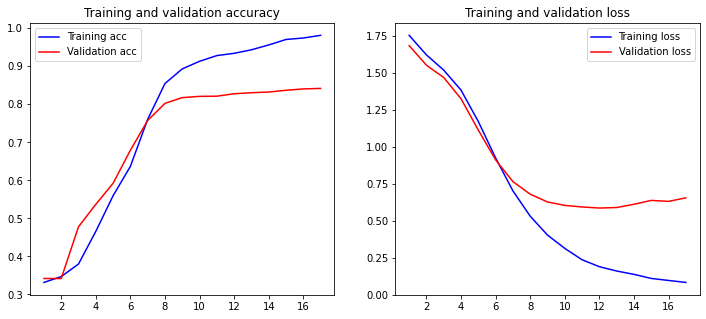

In [28]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)